# Bayesian inference

In [1]:
import sys, os
import logging
import numpy as np
from scipy.stats import uniform, norm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

sys.path.append('../')
import paper_settings
from simulation.units import *
from simulation.prior import get_grid
from inference.bayes import Posterior

In [2]:
paper_settings.setup()

## Setup

In [3]:
n_samples = (
    list(range(0,20)) + list(range(20,50,2))
    + list(range(50,100, 5)) + list(range(100,260, 10))
)

frame_time = 0.25  # s
frames = [8] + [1] * (len(n_samples) - 2) + [20]
total_frames = sum(frames)
len(n_samples), total_frames * frame_time, total_frames


(61, 21.75, 87)

In [4]:
filename = "calibrated_alices_full_sgd1e2_grid"
sample_seed = 200

In [5]:
def flat_prior(thetas):
    f_sub = thetas[:,0]
    beta = thetas[:,1]
    
    return uniform(0.001, 0.199).pdf(f_sub).flatten() * uniform(-2.5, 1.0).pdf(beta).flatten()

## Data

In [6]:
samples_per_frame = []
for i, f in enumerate(frames):
    samples_per_frame += [i] * f

In [7]:
n_max = n_samples[-1]
llr = np.load("../data/results/llr_{}.npy".format(filename))[:,sample_seed:sample_seed+n_max]

In [8]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Calculate posteriors on f_sub, beta

In [9]:
posteriors = []

for n in n_samples:
    if n == 0:
        posteriors.append(flat_prior(theta_grid))
    else:
        bayes = Posterior(llr[:,:n], theta_grid)
        posteriors.append(bayes.posterior_based_on_expected_llr(n, flat_prior))
                          
posteriors = np.array(posteriors)

## Drawing from posterior

In [10]:
def draw_fsub_beta(posterior):
    posterior /= np.sum(posterior)
    
    # Draw bin
    i_bin = np.random.choice(list(range(625)), p=posterior)
    
    # Draw f_sub and theta uniformly within bin
    f_sub = theta_grid[i_bin][0] + (f_sub_1d[1] - f_sub_1d[0]) * (np.random.random() - 0.5)
    beta = theta_grid[i_bin][1] + (beta_edges[1] - beta_edges[0]) * (np.random.random() - 0.5)
    
    return f_sub, beta

## SHMF

In [11]:
def M_200_sigma_v(sigma_v, scatter=False):
    """
    Relate central velocity dispersion to halo virial mass
    From https://arxiv.org/pdf/1804.04492.pdf
    """
    a = 0.09
    b = 3.48
    if scatter:
        sigma_log10_M_200 = 0.13  # Lognormal scatter
        log10_M_200 = np.random.normal(a + b * np.log10(sigma_v / (100 * Kmps)), sigma_log10_M_200)
    else:
        log10_M_200 = a + b * np.log10(sigma_v / (100 * Kmps))
    return (10 ** log10_M_200) * 1e12 * M_s

In [12]:
def shmf_by_mhost(fsub, beta, msubs):
    """ Evaluates dn / dm for a given set of m (msubs)"""
    
    sigma_v = np.random.normal(225, 50)
    mhost = M_200_sigma_v(sigma_v * Kmps)
    
    m_min_calib=1e6 * M_s
    m_max_calib=0.01 * mhost
    M_0=M_MW
    m_0 = 1.e9 * M_s
                
    alpha = fsub * ((2 + beta) * M_0 * m_0 ** beta) / (m_max_calib ** (beta + 2) - m_min_calib ** (beta + 2))
    
    return np.where(msubs > m_max_calib, 0., alpha * (mhost / M_0) * (msubs / m_0)**beta / mhost)
                

## Generate SHMF data

In [13]:
n_realizations = 10000
fsub_true, beta_true = 0.05, -1.9
msubs = np.geomspace(1.e7, 1e12, 100) * M_s

In [14]:
def mean_and_ci(samples, levels=[0.68, 0.95]):
    samples = samples[np.all(np.isfinite(samples),axis=1),:]
    mean = np.mean(samples, axis=0)
    all_down = [np.quantile(samples, (1. - level)/2, axis=0) for level in levels]
    all_up = [np.quantile(samples, 1. - (1. - level)/2, axis=0) for level in levels]
    all_cis = np.array([all_down, all_up])

    return mean, all_cis

In [15]:
shmfs = []
for _ in range(n_realizations):
    shmfs.append(shmf_by_mhost(fsub_true, beta_true, msubs))
shmf_true, _ = mean_and_ci(np.asarray(shmfs), levels=[])    # (n_datapoints)

In [16]:
shmf_posteriors = []
shmf_posterior_cis = []

for posterior_ in posteriors:
    shmfs = []
    for _ in range(n_realizations):
        fsub_, beta_ = draw_fsub_beta(posterior_)
        shmfs.append(shmf_by_mhost(fsub_, beta_, msubs))
        
    mean, ci = mean_and_ci(np.asarray(shmfs), levels=[0.68, 0.95])
    
    shmf_posteriors.append(mean)
    shmf_posterior_cis.append(ci)
    
shmf_posteriors = np.asarray(shmf_posteriors)  # (n_frames, n_datapoints)
shmf_posterior_cis = np.asarray(shmf_posterior_cis)  # (n_frames, 2, n_bands, n_datapoints)

/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [17]:
x = 1./M_s * msubs
y_mult = msubs**2

## Animation with only SHMF

In [18]:
def draw_frame(frame, show=False):
    step = samples_per_frame[frame]
    n = n_samples[step]
 
    # plt.clf()
    
    fillpost2 = plt.fill_between(x, y_mult * shmf_posterior_cis[step,0, 1], msubs**2 * shmf_posterior_cis[step,1, 1], facecolor=paper_settings.COLOR_FIX, edgecolor=paper_settings.COLOR_FIX)
    fillpost1 = plt.fill_between(x, y_mult * shmf_posterior_cis[step,0, 0], msubs**2 * shmf_posterior_cis[step,1, 0], facecolor=paper_settings.COLOR_ALIGN, edgecolor=paper_settings.COLOR_ALIGN)
    lpost, = plt.plot(x, y_mult * shmf_posteriors[step], alpha=1., c=paper_settings.COLOR_FULL, lw=1.0)
    ltrue, = plt.plot(x, y_mult * shmf_true, alpha=1., c="black", lw=1.0, ls=":")
    text = plt.text(2.e7, 1.4e-2, r"$n={}$".format(n), ha="left", va="bottom")
    
    plt.xlabel(r"$m_{200}$ [$M_{\odot}$]")
    ax.xaxis.set_label_coords(0.5, -0.11)
    plt.ylabel(r"$\frac {m_{200}^2}{M_{200}} \frac{\mathrm{d}n}{\mathrm{d}m_{200}}$")
    ax.yaxis.set_label_coords(-0.115, 0.5)
    ax.yaxis.set_ticks([0.,0.005,0.010])
    ax.yaxis.set_tick_params(pad=1)

    plt.xscale("log")
    plt.xlim(1.e7, 1.e12)
    plt.yscale("log")
    plt.ylim(0.001,0.02)
    
    if show:
        plt.show()
        return
    return [fillpost2, fillpost1, lpost, ltrue, text]
    

In [19]:
#fig, ax = paper_settings.figure()
#draw_frame(23, True)

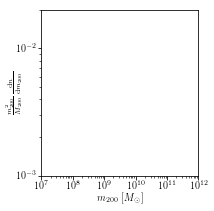

In [20]:
fig, ax = paper_settings.figure()
ims = [draw_frame(n) for n in range(total_frames)]
ani = animation.ArtistAnimation(fig, ims, interval=200)
ani.save('../figures/live_inference_shmf.gif', dpi=300, writer='imagemagick')

## Animation of only population-level parameters

In [21]:
def draw_frame(frame, show=False):
    step = samples_per_frame[frame]
    n = n_samples[step]
    
    pmin, pmax = 1.e-9, 0.05
    z = np.clip(posteriors[step], pmin + 1.e-9, pmax)
    z[~np.isfinite(z)] = pmin + 1.e-9
 
    # plt.clf()

    pcm = ax.imshow(
        z.reshape((resolution, resolution)),
        extent=(alpha_edges[0],alpha_edges[-1],beta_edges[0], beta_edges[-1]),
        cmap=paper_settings.CMAP2,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        norm=matplotlib.colors.LogNorm(vmin=pmin, vmax=pmax),
    )
    sc = ax.scatter(0.05, -1.9, s=15., color='black', marker='*')
    text = plt.text(0.145, -2.45, r"$n={}$".format(n), color="white", ha="left", va="bottom")
    
    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    plt.xlim(0.,0.2)
    plt.ylim(-2.5,-1.5) 
    plt.xticks([0.,0.05,0.1,0.15,0.2])
    plt.yticks([-1.6,-1.8,-2.0,-2.2,-2.4],["-0.6", "-0.8", "-1.0", "-1.2", "-1.4"])
    
    if show:
        plt.show()
        return
    return [pcm, sc, text]


In [22]:
#fig, ax = paper_settings.figure()
#draw_frame(11, True)

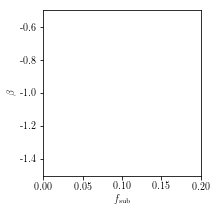

In [23]:
fig, ax = paper_settings.figure()
ims = [draw_frame(n) for n in range(total_frames)]
ani = animation.ArtistAnimation(fig, ims, interval=200)
ani.save('../figures/live_inference_population.gif', dpi=300, writer='imagemagick')

## Combined animation

In [33]:
def draw_frame(frame, show=False):
    step = samples_per_frame[frame]
    n = n_samples[step]
 
    # Left part
    plt.sca(ax_left)
    
    pmin, pmax = 1.e-9, 0.1
    z = np.clip(posteriors[step], pmin, pmax)
    z[~np.isfinite(z)] = pmin

    pcm = ax_left.imshow(
        z.reshape((resolution, resolution)),
        extent=(alpha_edges[0],alpha_edges[-1],beta_edges[0], beta_edges[-1]),
        cmap=paper_settings.CMAP2,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        norm=matplotlib.colors.LogNorm(vmin=pmin, vmax=pmax),
    )
    sc = ax_left.scatter(0.05, -1.9, s=15., color='black', marker='*')
    text2 = plt.text(0.145, -2.45, r"$n={}$".format(n), color="white", ha="left", va="bottom")
    
    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    plt.xlim(0.,0.2)
    plt.ylim(-2.5,-1.5) 
    plt.xticks([0.,0.05,0.1,0.15,0.2])
    plt.yticks([-1.6,-1.8,-2.0,-2.2,-2.4],["-0.6", "-0.8", "-1.0", "-1.2", "-1.4"])
    
    
    # Right part
    plt.sca(ax_right)
    
    fillpost2 = ax_right.fill_between(x, y_mult * shmf_posterior_cis[step,0, 1], msubs**2 * shmf_posterior_cis[step,1, 1], facecolor=paper_settings.COLOR_FIX, edgecolor=paper_settings.COLOR_FIX)
    fillpost1 = ax_right.fill_between(x, y_mult * shmf_posterior_cis[step,0, 0], msubs**2 * shmf_posterior_cis[step,1, 0], facecolor=paper_settings.COLOR_ALIGN, edgecolor=paper_settings.COLOR_ALIGN)
    lpost, = ax_right.plot(x, y_mult * shmf_posteriors[step], alpha=1., c=paper_settings.COLOR_FULL, lw=1.0)
    ltrue, = ax_right.plot(x, y_mult * shmf_true, alpha=1., c="black", lw=1.0, ls=":")
    text1 = plt.text(2.e7, 1.4e-2, r"$n={}$".format(n), ha="left", va="bottom")
    
    plt.xlabel(r"$m_{200}$ [$M_{\odot}$]")
    ax_right.xaxis.set_label_coords(0.5, -0.11)
    plt.ylabel(r"$\frac {m_{200}^2}{M_{200}} \frac{\mathrm{d}n}{\mathrm{d}m_{200}}$")
    ax_right.yaxis.set_label_coords(-0.115, 0.5)
    ax_right.yaxis.set_ticks([0.,0.005,0.010])
    ax_right.yaxis.set_tick_params(pad=1)

    plt.xscale("log")
    plt.xlim(1.e7, 1.e12)
    plt.yscale("log")
    plt.ylim(0.001,0.02)
    
    
    # Lens images
    #...
    
    
    # Done
    if show:
        plt.show()
        return
    return [pcm, sc, text1, fillpost2, fillpost1, lpost, ltrue, text2]


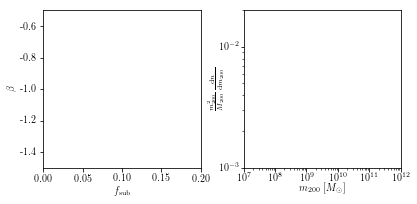

In [34]:
fig, ax_left, ax_right = paper_settings.two_figures()
ims = [draw_frame(n) for n in range(total_frames)]
ani = animation.ArtistAnimation(fig, ims, interval=200)
ani.save('../figures/live_inference_both.gif', dpi=300, writer='imagemagick')
